<a href="https://colab.research.google.com/github/n-bzy/iannwtf/blob/main/homework09_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from codecs import xmlcharrefreplace_errors
import os
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
from tensorflow.keras import layers
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.manifold import TSNE

from IPython import display

import urllib
categories = [line.rstrip(b'\n') for line in urllib.request.urlopen('https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt')]
print(categories[:10])
category = 'candle'

# Creates a folder to download the original drawings into.
# We chose to use the numpy format : 1x784 pixel vectors, with values going from 0 (white) to 255 (black). We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]

if not os.path.isdir('npy_files'):
    os.mkdir('npy_files')
    
url = f'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{category}.npy'  
urllib.request.urlretrieve(url, f'npy_files/{category}.npy')

images = np.load(f'npy_files/{category}.npy')
print(f'{len(images)} images to train on')

# You can limit the amount of images you use for training by setting :
train_images = images[:10000]
# You should also define a samller subset of the images for testing..
test_images = images[10000:12500]
# TODO

# Notice that this to numpy format contains 1x784 pixel vectors, with values going from 0 (white) to 255 (black). We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]
def preprocess(images, batch_size):
    images = tf.data.Dataset.from_tensor_slices(images)
    images = images.map(lambda img: tf.reshape(img, shape=(28,28,1)))
    images = images.map(lambda img: tf.cast(img, tf.float32))
    images = images.map(lambda img: (img/128 - 1.))
    images = images.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return images

batch_size = 32

train_images = preprocess(train_images, batch_size)
test_images = preprocess(test_images, batch_size)

[b'aircraft carrier', b'airplane', b'alarm clock', b'ambulance', b'angel', b'animal migration', b'ant', b'anvil', b'apple', b'arm']
141545 images to train on


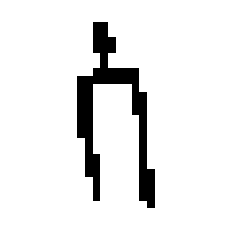

In [5]:
%matplotlib inline

# Display one exampe image of a candle
for x in train_images.take(1):
    img = tf.cast(tf.floor(x*128+1), tf.uint32)[-1,:,:,-1]
    plt.imshow(img, cmap='gray')
    plt.axis('off')

In [15]:
#The Generator
class gen(tf.keras.Model):
    def __init__(self):
        super(gen,self).__init__()

        self.dense1 = tf.keras.layers.Dense(98, input_shape=(98,))
        self.reshape = tf.keras.layers.Reshape((7,7,2))
        self.batchnorm = tf.keras.layers.BatchNormalization()
        self.conv1 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same', activation='relu')
        #size is now 14x14x128
        self.conv2 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')
        #size is now 28x28x64
        self.layer_out = tf.keras.layers.Conv2D(filters=1, kernel_size=3, padding='same', activation='tanh')
        #size is now 28x28x1

    @tf.function
    def __call__(self,x):
        x = self.dense1(x)
        x = self.reshape(x)
        x = self.batchnorm(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.layer_out(x)

        return x


#The Discriminator
class disc(tf.keras.Model):
    def __init__(self):
        super(disc,self).__init__()

        self.batchnorm = tf.keras.layers.BatchNormalization()
        #achtung, wenn nicht model.fit benutzt wird muss hier zwischen training true und false unterschieden werden weil dropout nur während des trainings aktiv ist 
        self.dropout = tf.keras.layers.Dropout(0.2)

        self.layer1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)
        # Image size 14x14
        self.layer2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')
        self.pool2 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)
        # Image size 7x7
        self.layer3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')
        self.pool3 = tf.keras.layers.GlobalAveragePooling2D()
        #Vector size 1x7
        self.layer_out = tf.keras.layers.Dense(1,activation = "sigmoid")

    @tf.function
    def __call__(self, x, train=True):
        x = self.batchnorm(x)
        x = self.dropout(x, training = train)
        x = self.layer1(x)
        x = self.pool1(x)
        x = self.layer2(x)
        x = self.pool2(x)
        x = self.layer3(x)
        x = self.pool3(x)
        x = self.layer_out(x)
        return x

#The complete network
class gan(tf.keras.Model):
    def __init__(self):
        super(gan,self).__init__()

        self.gen = gen()
        self.disc = disc()
        #specify metrics, optimizer, loss function
        self.metrics_list = [tf.keras.metrics.Mean(name="loss")]
        self.optimizer = tf.keras.optimizers.Adam()
        self.loss = tf.keras.losses.BinaryCrossentropy()

    #Noise for Generator
    """
    def get_noise():
        noise = tf.random.normal([batch_size, 1, 98])
        return noise
    """

    @tf.function
    def __call__(self,real,training=False):
        #noise = self.get_noise()
        noise = tf.random.normal([batch_size, 1, 98])
        fake = self.gen(noise)

        decide_fake = self.disc(fake, training)
        decide_real = self.disc(real, training)

        return decide_fake, decide_real

    @tf.function
    def train(self,data):
        real = data
        with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
            decision_fake, decision_real = self(real, training=True)
            #Loss Discriminator
            loss_fake = self.loss(decision_fake, tf.zeros_like(decision_fake))
            loss_real = self.loss(decision_real, tf.ones_like(decision_real))
            total_loss_disc = loss_fake + loss_real
            #Loss Generator (it's the negative loss for discriminator's loss regarding the fake images)
            loss_gen = - loss_fake

        #Adjust weights of Discriminator 
        gradients_disc = disc_tape.gradient(total_loss_disc, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients_disc, self.trainable_variables))
        self.metrics[0].update_state(total_loss_disc)

        #Adjust weights of Generator 
        gradients_gen = gen_tape.gradient(loss_gen, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients_gen, self.trainable_variables))
        self.metrics[0].update_state(loss_gen)

        return {m.name : m.result() for m in self.metrics}

    @tf.function
    def test(self,data):
        real = data
        decision_fake, decision_real = self(real, training=False)
        #Loss Discriminator
        loss_fake = self.loss(decision_fake, tf.zeros_like(decision_fake))
        loss_real = self.loss(decision_real, tf.ones_like(decision_real))
        total_loss_disc = loss_fake + loss_real
        #Loss Generator (its negative loss for discriminator's loss regarding the fake images)
        loss_gen = - loss_fake

        self.metrics[0].update_state(total_loss_disc)
        self.metrics[0].update_state(loss_gen)

        return {m.name : m.result() for m in self.metrics} 

def training_loop(model, train_images, test_images, epochs, generator):
    """Train and test the RNN for given epochs on given data"""

    # Save loss and accuracy as dictionaries in a list for visualization
    lists = []
    #Safe generated images
    img = []

    for n in range(epochs):
        print(f"Epoch {n}:")

        for data in tqdm.tqdm(train_images, position=0, leave=True):
            metrics = model.train(data)

        # Add metrics to list
        lists.append(metrics)
        print([f"{key}: {value.numpy()}" for (key,value) in metrics.items()])
        model.reset_metrics()

        for data in tqdm.tqdm(test_images, position=0, leave=True):
            metrics = model.test(data)

        # Add metrics to list
        lists.append(metrics)
        print([f"{key}: {value.numpy()}" for (key,value) in metrics.items()])
        model.reset_metrics()
        
        #Create Image with generator and safe it
        new_noise = tf.random.normal([batch_size, 1, 98])
        img.append(generator(new_noise))

    return lists

#initialize model
model = gan()
generator = gen()
#train network
li = training_loop(model, train_images, test_images, 5, generator)

Epoch 0:


100%|██████████| 313/313 [00:08<00:00, 37.16it/s] 


['loss: 0.021883388981223106']


100%|██████████| 79/79 [00:00<00:00, 101.48it/s]


['loss: 0.0001178813909064047']
Epoch 1:


100%|██████████| 313/313 [00:02<00:00, 114.69it/s]


['loss: 1.1075419479311677e-06']


100%|██████████| 79/79 [00:00<00:00, 271.13it/s]


['loss: 0.00011116341920569539']
Epoch 2:


100%|██████████| 313/313 [00:02<00:00, 114.88it/s]


['loss: 1.0024244829764939e-06']


100%|██████████| 79/79 [00:00<00:00, 277.83it/s]


['loss: 0.00010611738980514929']
Epoch 3:


100%|██████████| 313/313 [00:02<00:00, 115.18it/s]


['loss: 9.658618864705204e-07']


100%|██████████| 79/79 [00:00<00:00, 261.48it/s]


['loss: 0.00010072128497995436']
Epoch 4:


100%|██████████| 313/313 [00:02<00:00, 112.04it/s]


['loss: 9.612915619072737e-07']


100%|██████████| 79/79 [00:00<00:00, 272.70it/s]

['loss: 9.468537609791383e-05']


(28,)


TypeError: ignored

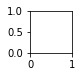

In [17]:
# Geklaut
# Display the images created by the Generator while training
k = 1
plt.figure(figsize=(25,10))

for x in img:
    # Reduce dimensionality of images for displaying to 2D (remove batch and color channel)
    #x = np.squeeze(x, axis=0)
    #x = np.squeeze(x, axis=-1)
    print(x.shape)
    plt.subplot(1, len(img), k)
    plt.imshow(x, cmap='gray')
    plt.axis('off')
    k += 1

plt.show()